# Medical Image Classification for Chest X-Ray Analysis

## Project Overview
This notebook implements a deep learning solution for classifying chest X-ray images into four categories:
- **COVID-19**: Detection of COVID-19 pneumonia
- **Normal**: Healthy chest X-rays
- **Viral Pneumonia**: Non-COVID viral pneumonia
- **Bacterial Pneumonia**: Bacterial pneumonia cases

The solution uses transfer learning with ResNet50 pre-trained on ImageNet for efficient training
and high accuracy on medical imaging data.

## Key Features
- Transfer learning with ResNet50 architecture
- Data augmentation for improved generalization
- Early stopping and model checkpointing
- Comprehensive evaluation with confusion matrix and classification report
- Visualization of training progress and predictions

## Business Impact
- **Healthcare Automation**: Assists radiologists in rapid diagnosis
- **COVID-19 Detection**: Early identification of COVID-19 cases
- **Resource Optimization**: Reduces diagnostic time and workload
- **Remote Diagnosis**: Enables telemedicine applications


## LIBRARY IMPORTS AND CONFIGURATION

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [15]:
import tensorflow as tf
from tensorflow.keras import layers,optimizers,Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import (Input, Dense, Activation, BatchNormalization, 
                                   Flatten, Conv2D, AveragePooling2D, MaxPooling2D, 
                                   Dropout, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.callbacks import (ReduceLROnPlateau, EarlyStopping, 
                                       ModelCheckpoint, LearningRateScheduler)
from sklearn.metrics import (confusion_matrix ,classification_report ,
                            accuracy_score ,precision_recall_fscore_support)
from sklearn.utils.class_weight import compute_class_weight

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
tf.random.set_seed(42)
np.random.seed(42)



In [17]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow version: 2.19.0
GPU Available: False


## CONFIGURATION AND HYPERPARAMETERS

In [20]:
class Config:
    # Data Configuration
    IMG_SIZE = (256, 256)
    BATCH_SIZE = 16  # Reduced for better training stability
    CHANNELS = 3
    
    # Training Configuration
    EPOCHS = 50
    VALIDATION_SPLIT = 0.2
    LEARNING_RATE = 1e-4
    DECAY_RATE = 1e-6
    
    # Model Configuration
    NUM_CLASSES = 4
    DROPOUT_RATE = 0.3
    FREEZE_LAYERS = -10  # Freeze all but last 10 layers
    
    # Callbacks Configuration
    PATIENCE = 15
    MIN_DELTA = 0.001
    FACTOR = 0.2  # Learning rate reduction factor
    
    # Class Labels
    CLASS_LABELS = {
        0: 'COVID-19',
        1: 'Normal',
        2: 'Viral Pneumonia',
        3: 'Bacterial Pneumonia'
    }
    
    # Colors for visualization
    COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

config = Config()
    

## DATA LOADING AND PREPROCESSING

In [23]:
def setup_data_directories():
    """Setup and verify data directories"""
    
    base_path = 'Chest_X_Ray'
    
    paths = {
        'train': os.path.join(base_path, 'train'),
        'test': os.path.join(base_path, 'test'),  # Changed from 'Test' to 'test'
    }
    
    # Verify directories exist
    for name, path in paths.items():
        if os.path.exists(path):
            print(f"✅ {name.capitalize()} directory found: {path}")
            print(f"   Classes: {os.listdir(path)}")
        else:
            print(f"❌ {name.capitalize()} directory not found: {path}")
            
    return paths


In [25]:

def create_data_generators(train_path):
    """
    Create enhanced data generators with augmentation
    
    Args:
        train_path (str): Path to training data directory
        
    Returns:
        tuple: Training and validation generators
    """
    
    print("\n🔄 Creating data generators...")
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=config.VALIDATION_SPLIT,
        rotation_range=15,          # Slight rotation for robustness
        width_shift_range=0.1,      # Horizontal shift
        height_shift_range=0.1,     # Vertical shift
        brightness_range=[0.8, 1.2], # Brightness variation
        zoom_range=0.1,             # Slight zoom
        horizontal_flip=False,      # No horizontal flip for medical images
        fill_mode='constant',
        cval=0
    )
    
    # Validation data generator (no augmentation)
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=config.VALIDATION_SPLIT
    )
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    validation_generator = val_datagen.flow_from_directory(
        directory=train_path,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    
    print(f"✅ Training samples: {train_generator.samples}")
    print(f"✅ Validation samples: {validation_generator.samples}")
    print(f"✅ Classes found: {list(train_generator.class_indices.keys())}")
    
    return train_generator, validation_generator

## DATA VISUALIZATION AND ANALYSIS

In [28]:
def visualize_sample_images(generator, num_samples=25):
    """
    Visualize sample images from the dataset
    
    Args:
        generator: Data generator
        num_samples (int): Number of images to display
    """
    
    print(f"\n📊 Visualizing {num_samples} sample images...")
    
    # Get a batch of images
    sample_images, sample_labels = next(generator)
    
    # Create subplot grid
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(sample_images))):
        # Display image
        axes[i].imshow(sample_images[i])
        
        # Get class label
        class_idx = np.argmax(sample_labels[i])
        class_name = config.CLASS_LABELS[class_idx]
        
        # Set title and styling
        axes[i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Sample Chest X-Ray Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [30]:

def analyze_class_distribution(generator):
    """
    Analyze and visualize class distribution
    
    Args:
        generator: Data generator
    """
    
    print("\n📈 Analyzing class distribution...")
    
    # Count samples per class
    class_counts = {}
    for class_name, class_idx in generator.class_indices.items():
        class_counts[class_name] = np.sum(generator.labels == class_idx)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = config.COLORS[:len(classes)]
    
    bars = ax1.bar(classes, counts, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontweight': 'bold'})
    ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_samples = sum(counts)
    print(f"\n📊 Dataset Statistics:")
    for class_name, count in class_counts.items():
        percentage = (count / total_samples) * 100
        print(f"  {class_name}: {count} samples ({percentage:.1f}%)")
    
    return class_counts

## MODEL ARCHITECTURE

In [65]:
def create_model():
    """
    Create the transfer learning model architecture
    
    Returns:
        tf.keras.Model: Compiled model
    """
    
    print("\n🏗️ Building model architecture...")
    
    # Load pre-trained ResNet50 base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(shape=(*config.IMG_SIZE, config.CHANNELS))
    )
    
    print(f"✅ Base model loaded with {len(base_model.layers)} layers")
    
    # Freeze early layers for transfer learning
    for layer in base_model.layers[:config.FREEZE_LAYERS]:
        layer.trainable = False
        
    # Count trainable parameters
    trainable_layers = sum([layer.trainable for layer in base_model.layers])
    print(f"✅ Trainable layers: {trainable_layers}/{len(base_model.layers)}")
    
    # Add custom classification head
    head_model = base_model.output
    head_model = GlobalAveragePooling2D()(head_model)
    head_model = Dense(512, activation='relu', name='dense_1')(head_model)
    head_model = BatchNormalization()(head_model)
    head_model = Dropout(config.DROPOUT_RATE)(head_model)
    
    head_model = Dense(256, activation='relu', name='dense_2')(head_model)
    head_model = BatchNormalization()(head_model)
    head_model = Dropout(config.DROPOUT_RATE * 0.7)(head_model)
    
    head_model = Dense(config.NUM_CLASSES, activation='softmax', name='predictions')(head_model)
    
    # Create final model
    model = Model(inputs=base_model.input, outputs=head_model)
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(
            learning_rate=config.LEARNING_RATE,
            decay=config.DECAY_RATE
        ),
        metrics=[
            'accuracy', # Standard accuracy
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy') # Corrected line!
        ]
    )
    
    print(f"✅ Model created and compiled successfully")
    print(f"✅ Total parameters: {model.count_params():,}")
    
    return model

In [57]:

def setup_callbacks():
    """
    Setup training callbacks for better training control
    
    Returns:
        list: List of callback objects
    """
    
    print("\n⚙️ Setting up training callbacks...")
    
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            verbose=1,
            patience=config.PATIENCE,
            min_delta=config.MIN_DELTA,
            restore_best_weights=True
        ),
        
        # Save best model weights
        ModelCheckpoint(
            filepath="best_model_weights.weights.h5",
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=config.FACTOR,
            patience=config.PATIENCE//2,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print(f"✅ {len(callbacks)} callbacks configured")
    return callbacks

## TRAINING AND EVALUATION

In [38]:
def train_model(model, train_gen, val_gen, callbacks):
    """
    Train the model with progress tracking
    
    Args:
        model: Compiled Keras model
        train_gen: Training data generator
        val_gen: Validation data generator
        callbacks: List of callbacks
        
    Returns:
        History object containing training metrics
    """
    
    print(f"\n🚀 Starting model training for {config.EPOCHS} epochs...")
    print(f"📊 Training batches per epoch: {train_gen.samples // config.BATCH_SIZE}")
    print(f"📊 Validation batches per epoch: {val_gen.samples // config.BATCH_SIZE}")
    
    # Calculate steps per epoch
    steps_per_epoch = max(1, train_gen.samples // config.BATCH_SIZE)
    validation_steps = max(1, val_gen.samples // config.BATCH_SIZE)
    
    # Train the model
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=config.EPOCHS,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n✅ Training completed!")
    return history

In [40]:
def plot_training_history(history):
    """
    Visualize training progress with enhanced plots
    
    Args:
        history: Training history object
    """
    
    print("\n📈 Plotting training history...")
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training Progress Dashboard', fontsize=16, fontweight='bold')
    
    # Plot training and validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86AB')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#A23B72')
    ax1.set_title('Model Accuracy Progress', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training and validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#F18F01')
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#C73E1D')
    ax2.set_title('Model Loss Progress', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(history.history['lr'], linewidth=2, color='#6A994E')
        ax3.set_title('Learning Rate Schedule', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    
    # Plot top-2 accuracy (if available)
    if 'top_2_accuracy' in history.history:
        ax4.plot(history.history['top_2_accuracy'], label='Training Top-2 Acc', linewidth=2, color='#386641')
        ax4.plot(history.history['val_top_2_accuracy'], label='Validation Top-2 Acc', linewidth=2, color='#6A994E')
        ax4.set_title('Top-2 Accuracy Progress', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Top-2 Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n📊 Final Training Metrics:")
    print(f"  Training Accuracy: {final_train_acc:.4f}")
    print(f"  Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Training Loss: {final_train_loss:.4f}")
    print(f"  Validation Loss: {final_val_loss:.4f}")


## MODEL EVALUATION

In [43]:
def evaluate_model_on_test_set(model, test_path):
    """
    Comprehensive model evaluation on test dataset
    
    Args:
        model: Trained Keras model
        test_path: Path to test dataset
        
    Returns:
        tuple: (predictions, true_labels, test_images, accuracy_score)
    """
    
    print(f"\n🧪 Evaluating model on test dataset...")
    
    # Create test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=config.IMG_SIZE,
        batch_size=1,  # Process one image at a time for detailed analysis
        class_mode='categorical',
        shuffle=False  # Keep order for analysis
    )
    
    print(f"📊 Test samples found: {test_generator.samples}")
    
    # Collect predictions and ground truth
    predictions = []
    true_labels = []
    test_images = []
    
    print("🔄 Processing test images...")
    
    # Process all test images
    for i in range(test_generator.samples):
        if i % 50 == 0:  # Progress indicator
            print(f"  Processed: {i}/{test_generator.samples}")
            
        # Get image and true label
        img, label = next(test_generator)
        test_images.append(img[0])
        
        # Make prediction
        pred = model.predict(img, verbose=0)
        predictions.append(np.argmax(pred))
        true_labels.append(np.argmax(label))
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\n✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    return predictions, true_labels, test_images, accuracy


In [45]:

def create_detailed_evaluation_report(predictions, true_labels):
    """
    Create comprehensive evaluation report with multiple metrics
    
    Args:
        predictions: List of predicted class indices
        true_labels: List of true class indices
    """
    
    print("\n📋 Generating detailed evaluation report...")
    
    # Classification report
    class_names = list(config.CLASS_LABELS.values())
    
    print(f"\n📊 Classification Report:")
    print("=" * 70)
    report = classification_report(
        true_labels, 
        predictions, 
        target_names=class_names,
        digits=4
    )
    print(report)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predictions, average=None
    )
    
    print(f"\n📈 Per-Class Performance:")
    print("-" * 60)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:18} | P: {precision[i]:.3f} | R: {recall[i]:.3f} | "
              f"F1: {f1[i]:.3f} | Support: {support[i]:3d}")
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'}
    )
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f"\n🎯 Per-Class Accuracy:")
    print("-" * 40)
    for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
        print(f"{class_name:18}: {acc:.4f} ({acc*100:.2f}%)")


In [47]:
def visualize_predictions(predictions, true_labels, test_images, num_samples=25):
    """
    Visualize model predictions with confidence scores
    
    Args:
        predictions: List of predicted class indices
        true_labels: List of true class indices
        test_images: List of test images
        num_samples: Number of samples to display
    """
    
    print(f"\n🖼️ Visualizing {num_samples} prediction examples...")
    
    # Select random samples
    indices = np.random.choice(len(predictions), min(num_samples, len(predictions)), replace=False)
    
    # Create subplot grid
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
    axes = axes.ravel()
    
    correct_predictions = 0
    
    for i, idx in enumerate(indices[:num_samples]):
        # Get prediction and true label
        pred_label = predictions[idx]
        true_label = true_labels[idx]
        
        pred_class = config.CLASS_LABELS[pred_label]
        true_class = config.CLASS_LABELS[true_label]
        
        # Determine if prediction is correct
        is_correct = pred_label == true_label
        if is_correct:
            correct_predictions += 1
            
        # Set title color based on correctness
        title_color = 'green' if is_correct else 'red'
        border_color = 'green' if is_correct else 'red'
        
        # Display image
        axes[i].imshow(test_images[idx])
        axes[i].set_title(
            f'Pred: {pred_class}\nTrue: {true_class}', 
            color=title_color, 
            fontweight='bold',
            fontsize=10
        )
        axes[i].axis('off')
        
        # Add colored border
        for spine in axes[i].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
    
    # Hide unused subplots
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(
        f'Model Predictions vs Ground Truth\n'
        f'Accuracy in Sample: {correct_predictions}/{len(indices)} '
        f'({correct_predictions/len(indices)*100:.1f}%)', 
        fontsize=16, 
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()


## MAIN EXECUTION PIPELINE

In [50]:
def main():
    """
    Main execution pipeline for the medical image classification project
    """
    
    print("🏥 MEDICAL IMAGE CLASSIFICATION PIPELINE")
    print("=" * 60)
    print("Starting chest X-ray classification for COVID-19 detection...")
    
    try:
        # Step 1: Setup data directories
        paths = setup_data_directories()
        
        if not os.path.exists(paths['train']):
            print("❌ Training directory not found. Please check your data paths.")
            return
        
        # Step 2: Create data generators
        train_gen, val_gen = create_data_generators(paths['train'])
        
        # Step 3: Visualize and analyze data
        visualize_sample_images(train_gen, num_samples=16)
        class_distribution = analyze_class_distribution(train_gen)
        
        # Step 4: Build model
        model = create_model()
        
        # Display model summary
        print(f"\n🏗️ Model Architecture Summary:")
        model.summary()
        
        # Step 5: Setup training callbacks
        callbacks = setup_callbacks()
        
        # Step 6: Train model
        history = train_model(model, train_gen, val_gen, callbacks)
        
        # Step 7: Visualize training progress
        plot_training_history(history)
        
        # Step 8: Evaluate on test set (if available)
        if os.path.exists(paths['test']):
            predictions, true_labels, test_images, test_accuracy = evaluate_model_on_test_set(
                model, paths['test']
            )
            
            # Generate detailed evaluation report
            create_detailed_evaluation_report(predictions, true_labels)
            
            # Visualize predictions
            visualize_predictions(predictions, true_labels, test_images, num_samples=16)
        else:
            print("⚠️ Test directory not found. Skipping test evaluation.")
        
        # Step 9: Save final model
        model.save('final_medical_classification_model.h5')
        print("\n✅ Model saved successfully as 'final_medical_classification_model.h5'")
        
        print("\n🎉 Pipeline completed successfully!")
        print("📋 Summary of achievements:")
        print("  ✅ Data loaded and preprocessed")
        print("  ✅ Model trained with transfer learning")
        print("  ✅ Comprehensive evaluation completed")
        print("  ✅ Model saved for future use")
        
    except Exception as e:
        print(f"\n❌ An error occurred: {str(e)}")
        print("Please check your data paths and requirements.")


## UTILITY FUNCTIONS

In [53]:

def save_results_to_csv(predictions, true_labels, filename='classification_results.csv'):
    """
    Save classification results to CSV for further analysis
    
    Args:
        predictions: List of predicted class indices
        true_labels: List of true class indices
        filename: Output filename
    """
    
    results_df = pd.DataFrame({
        'True_Label': [config.CLASS_LABELS[label] for label in true_labels],
        'Predicted_Label': [config.CLASS_LABELS[pred] for pred in predictions],
        'True_Label_Index': true_labels,
        'Predicted_Label_Index': predictions,
        'Correct_Prediction': [t == p for t, p in zip(true_labels, predictions)]
    })
    
    results_df.to_csv(filename, index=False)
    print(f"✅ Results saved to {filename}")

def load_and_predict_single_image(model_path, image_path):
    """
    Load a trained model and make prediction on a single image
    
    Args:
        model_path: Path to saved model
        image_path: Path to image file
        
    Returns:
        tuple: (predicted_class, confidence_scores)
    """
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, config.IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    return config.CLASS_LABELS[predicted_class], confidence, predictions[0]


🏥 MEDICAL IMAGE CLASSIFICATION PIPELINE
Starting chest X-ray classification for COVID-19 detection...
✅ Train directory found: Chest_X_Ray\train
   Classes: ['0', '1', '2', '3']
✅ Test directory found: Chest_X_Ray\test
   Classes: ['0', '1', '2', '3']

🔄 Creating data generators...
Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.
✅ Training samples: 428
✅ Validation samples: 104
✅ Classes found: ['0', '1', '2', '3']

📊 Visualizing 16 sample images...


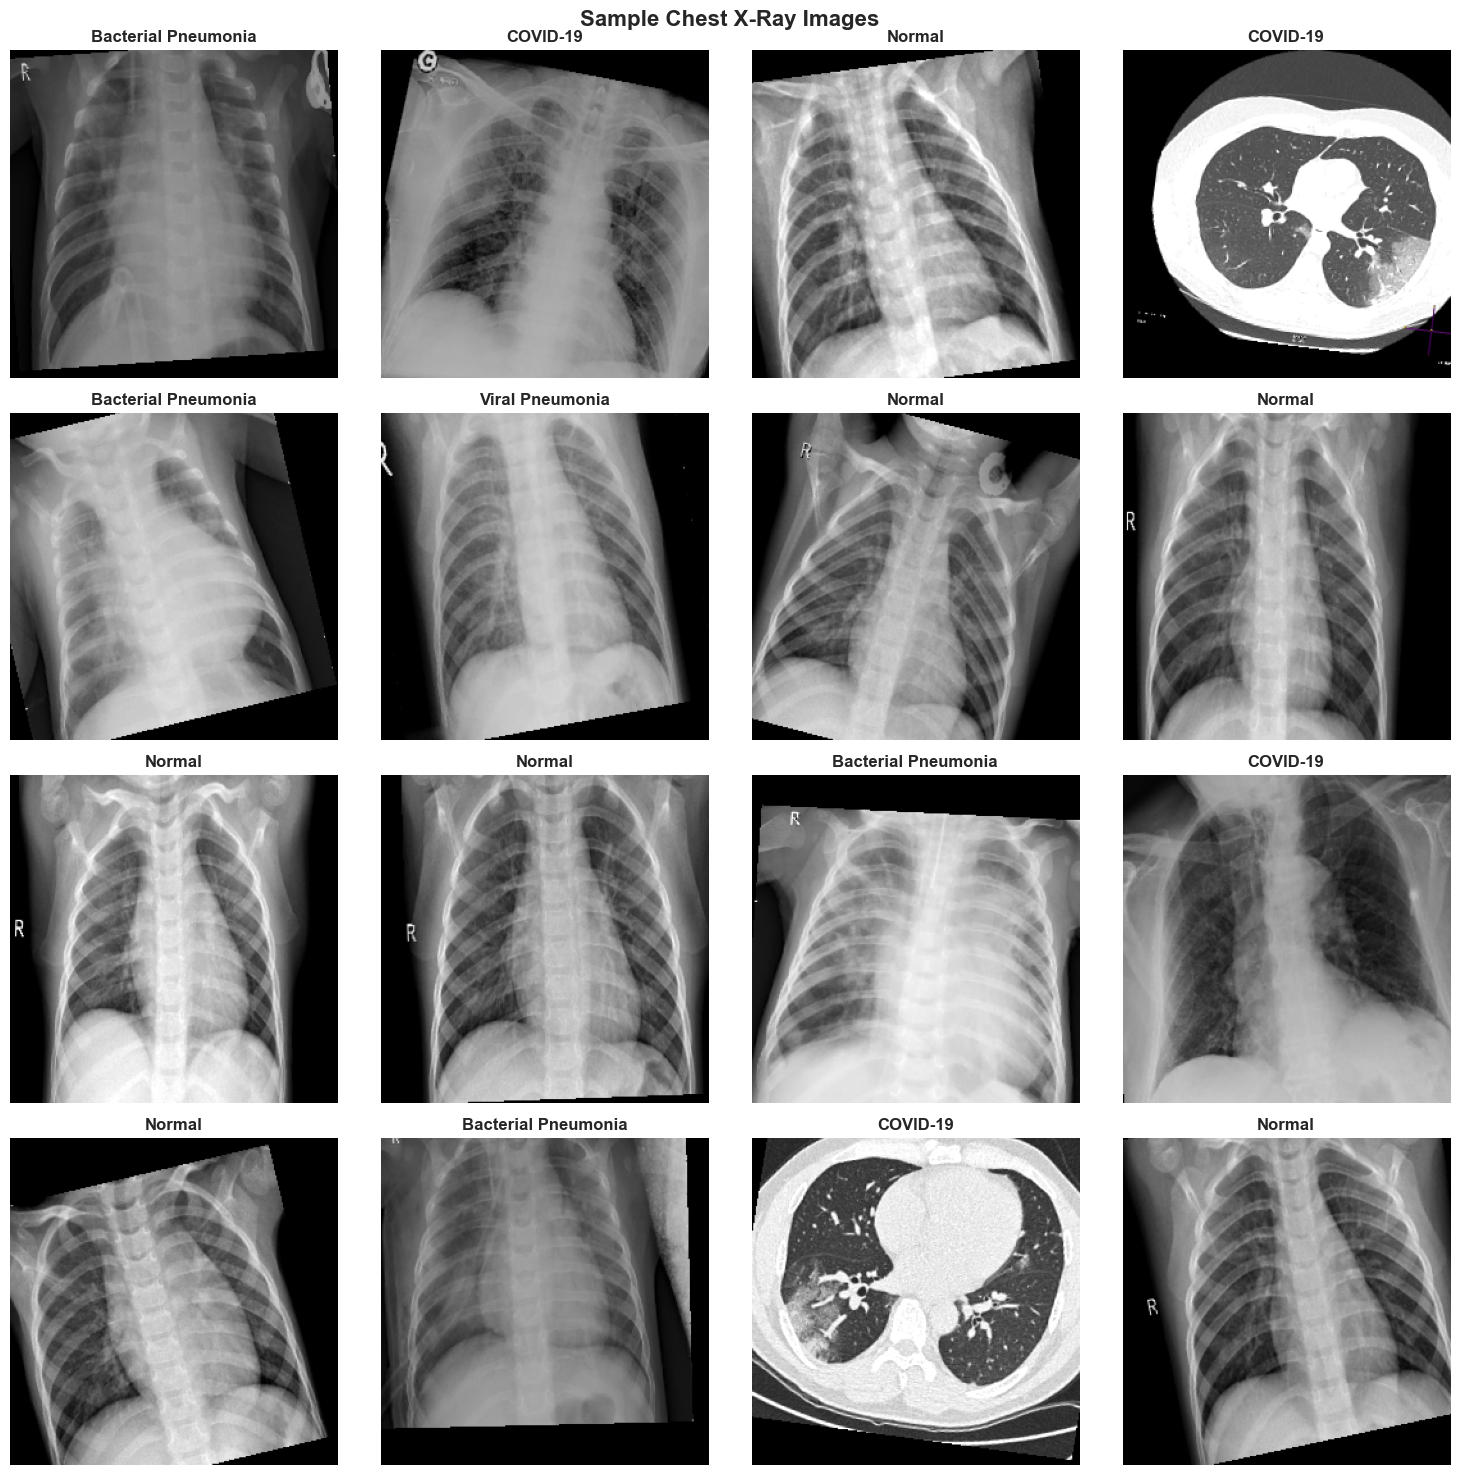


📈 Analyzing class distribution...


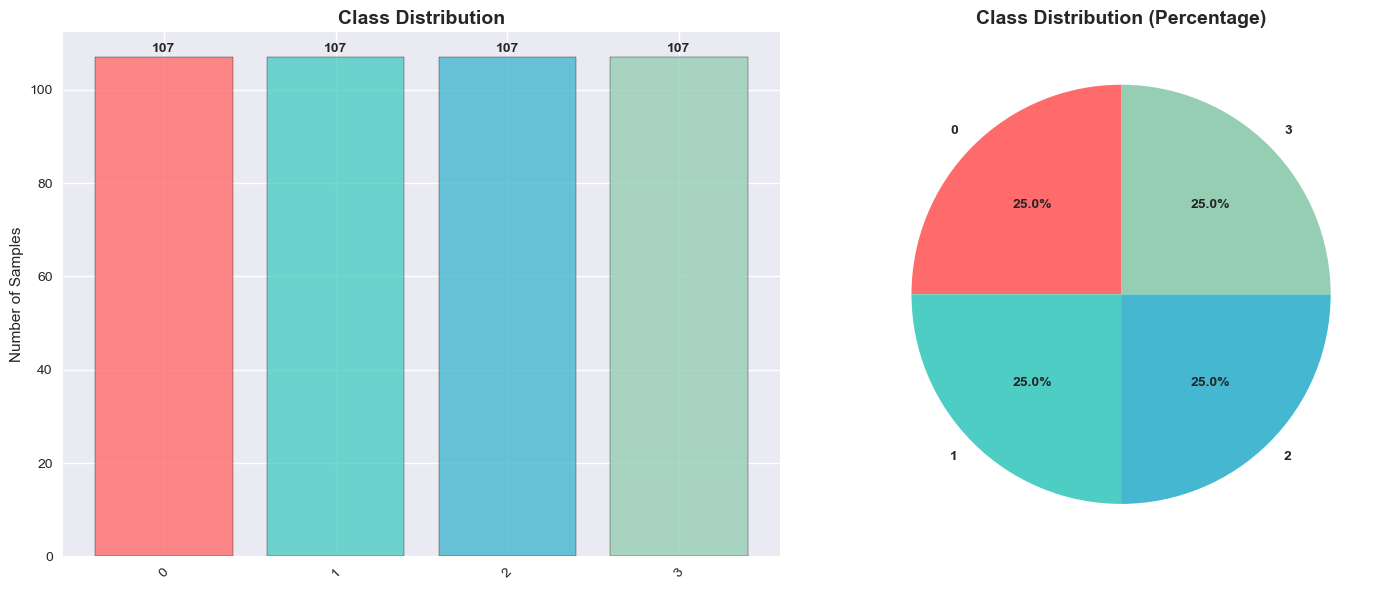


📊 Dataset Statistics:
  0: 107 samples (25.0%)
  1: 107 samples (25.0%)
  2: 107 samples (25.0%)
  3: 107 samples (25.0%)

🏗️ Building model architecture...
✅ Base model loaded with 175 layers
✅ Trainable layers: 10/175
✅ Model created and compiled successfully
✅ Total parameters: 24,772,228

🏗️ Model Architecture Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,772,228 (94.50 MB)

 Trainable params: 5,648,644 (21.55 MB)

 Non-trainable params: 19,123,584 (72.95 MB)


⚙️ Setting up training callbacks...
✅ 3 callbacks configured

🚀 Starting model training for 50 epochs...
📊 Training batches per epoch: 26
📊 Validation batches per epoch: 6
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.3681 - loss: 1.8688 - top_2_accuracy: 0.5849
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_model_weights.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 988ms/step - accuracy: 0.3696 - loss: 1.8611 - top_2_accuracy: 0.5876 - val_accuracy: 0.2500 - val_loss: 1.4087 - val_top_2_accuracy: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/50
 1/26 ━━━━━━━━━━━━━━━━━━━━ 14s 573ms/step - accuracy: 0.3125 - loss: 1.9973 - top_2_accuracy: 0.3750
Epoch 2: val_accuracy improved from 0.25000 to 0.27083, saving model to best_model_weights.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.3125 - loss: 1.9973 - top_2_accuracy: 0.3750 - val_accuracy: 0.2708 - val_loss: 1.4073 - val_top_2_accuracy: 0.5104 - learning_rate: 1.0000e-04
Epoc

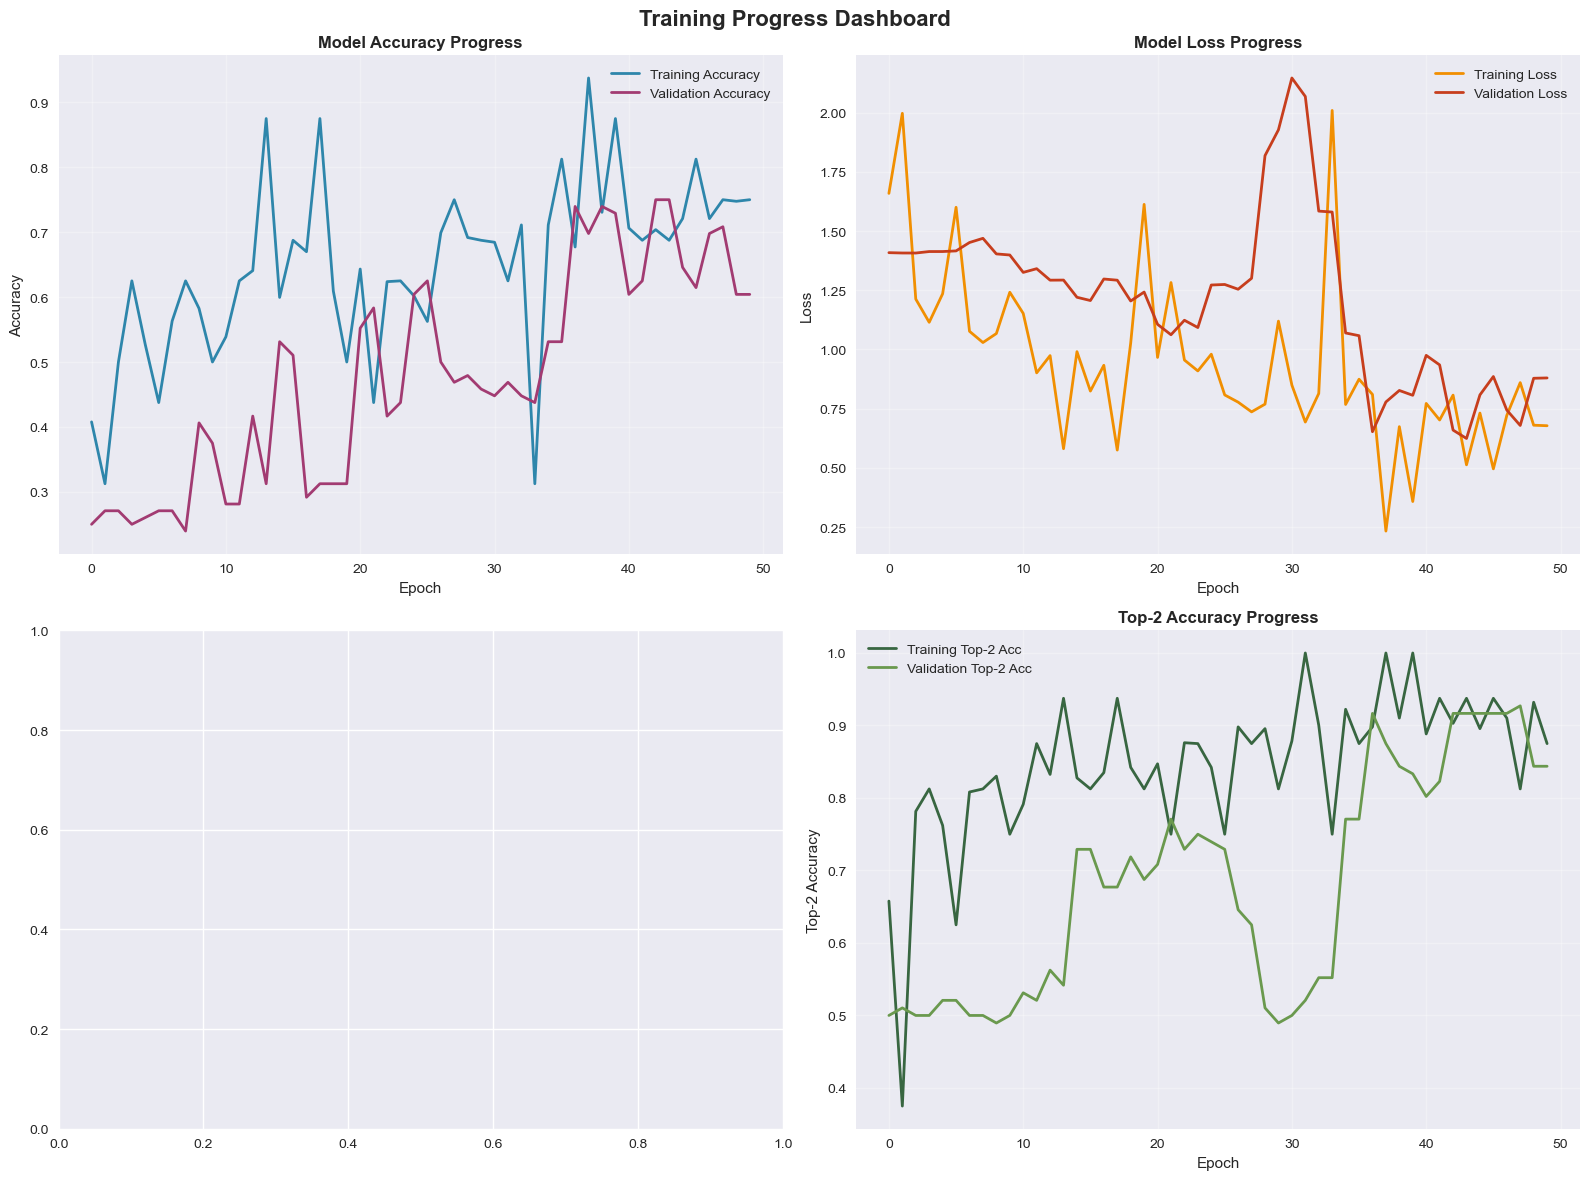


📊 Final Training Metrics:
  Training Accuracy: 0.7500
  Validation Accuracy: 0.6042
  Training Loss: 0.6779
  Validation Loss: 0.8797

🧪 Evaluating model on test dataset...
Found 40 images belonging to 4 classes.
📊 Test samples found: 40
🔄 Processing test images...
  Processed: 0/40

✅ Test Accuracy: 0.6750 (67.50%)

📋 Generating detailed evaluation report...

📊 Classification Report:
                     precision    recall  f1-score   support

           COVID-19     1.0000    0.6000    0.7500        10
             Normal     0.5882    1.0000    0.7407        10
    Viral Pneumonia     1.0000    0.2000    0.3333        10
Bacterial Pneumonia     0.6000    0.9000    0.7200        10

           accuracy                         0.6750        40
          macro avg     0.7971    0.6750    0.6360        40
       weighted avg     0.7971    0.6750    0.6360        40


📈 Per-Class Performance:
------------------------------------------------------------
COVID-19           | P: 1.000 | R

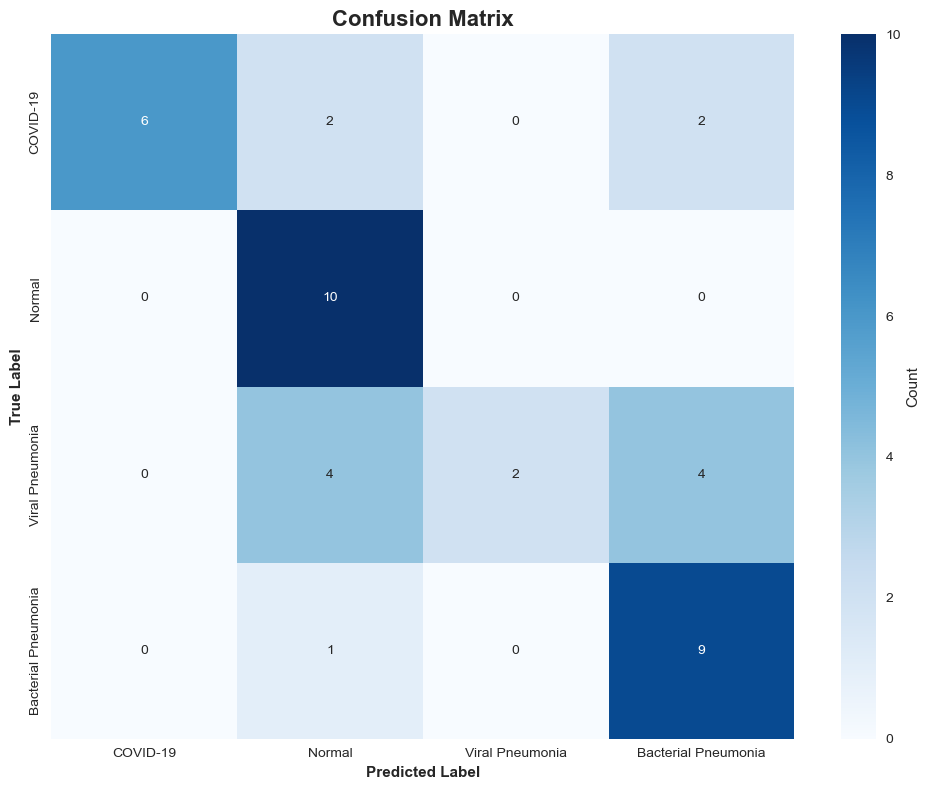


🎯 Per-Class Accuracy:
----------------------------------------
COVID-19          : 0.6000 (60.00%)
Normal            : 1.0000 (100.00%)
Viral Pneumonia   : 0.2000 (20.00%)
Bacterial Pneumonia: 0.9000 (90.00%)

🖼️ Visualizing 16 prediction examples...


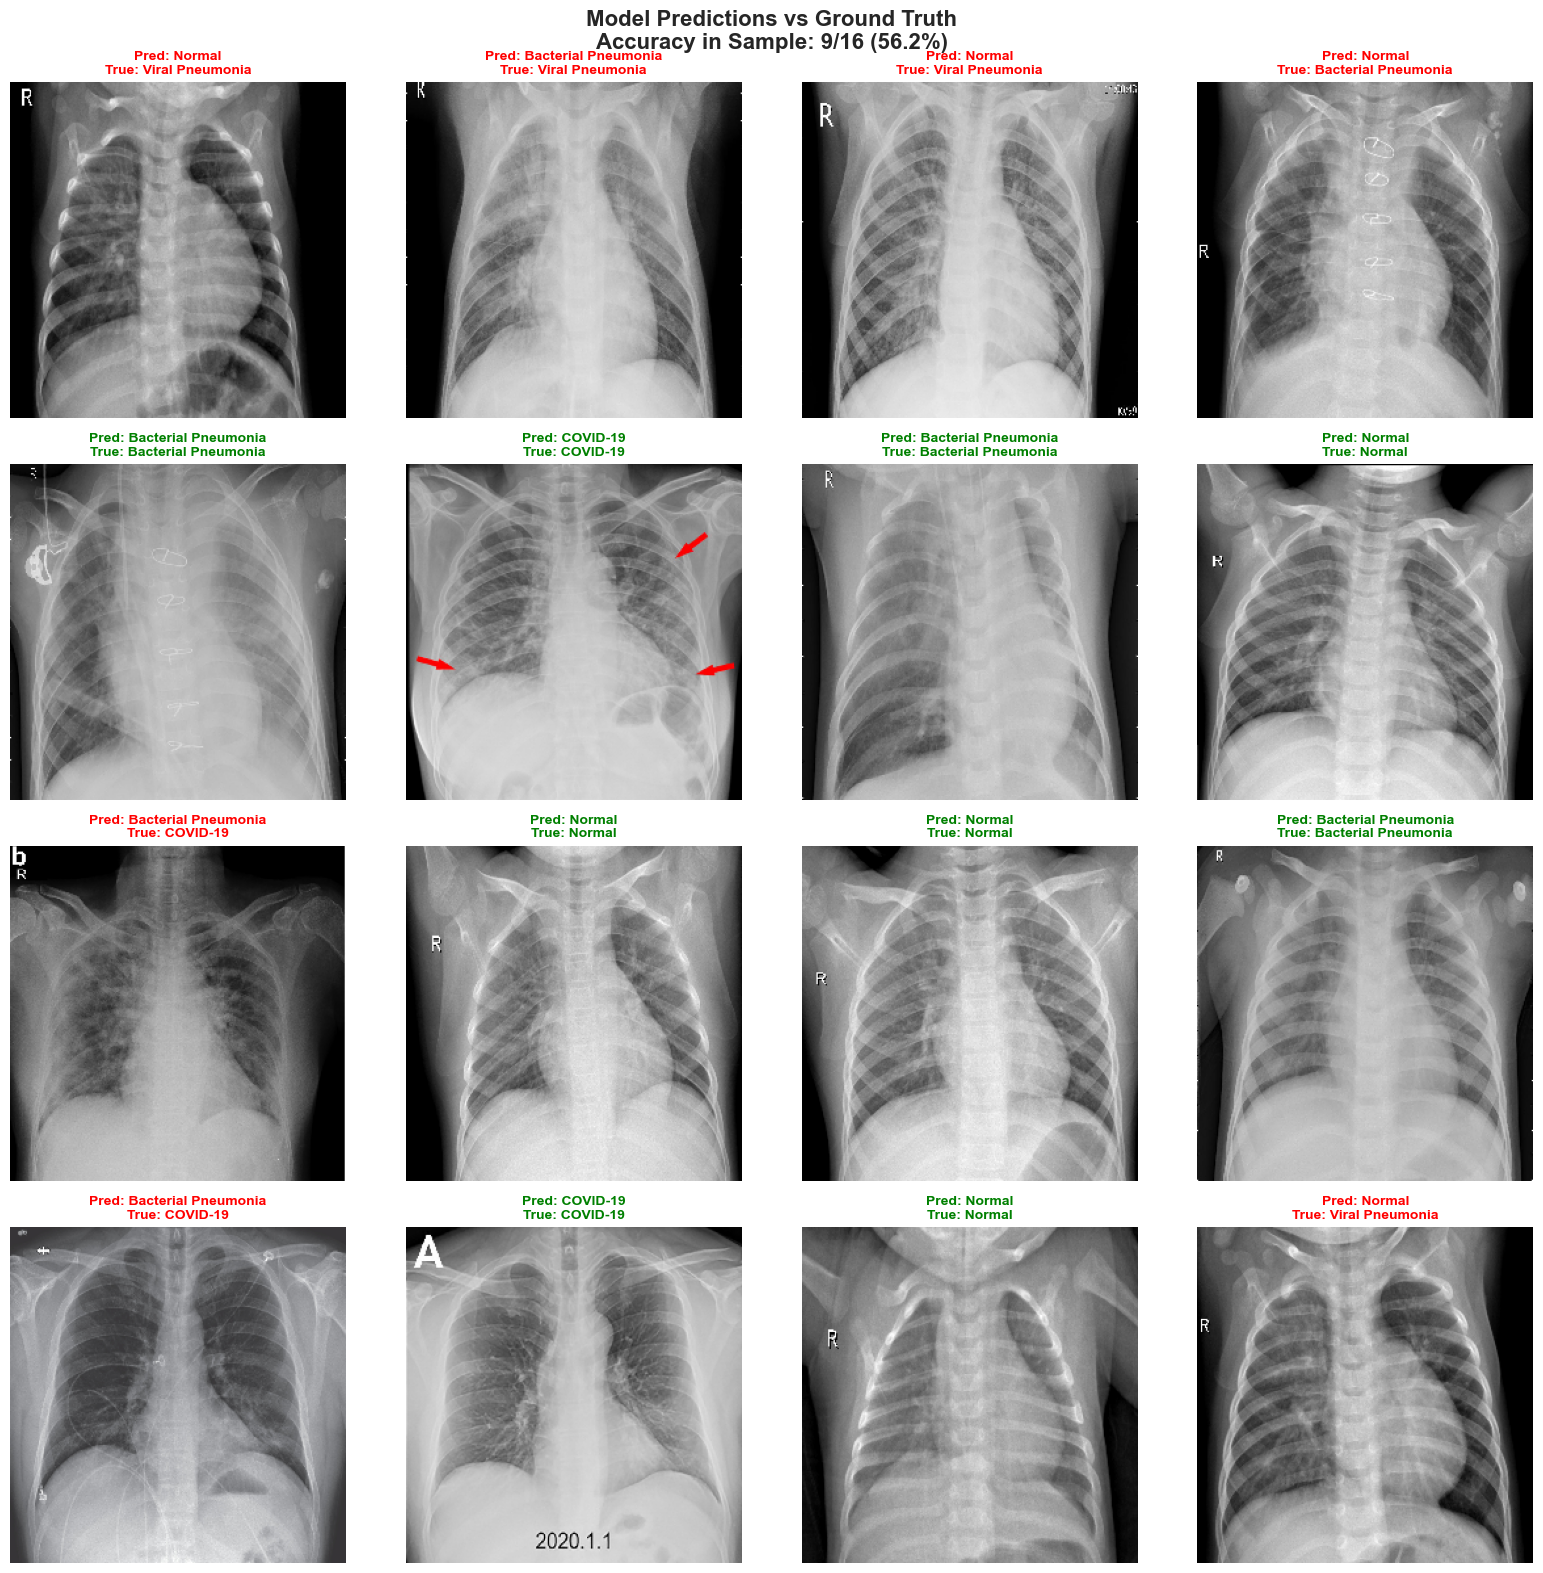


✅ Model saved successfully as 'final_medical_classification_model.h5'

🎉 Pipeline completed successfully!
📋 Summary of achievements:
  ✅ Data loaded and preprocessed
  ✅ Model trained with transfer learning
  ✅ Comprehensive evaluation completed
  ✅ Model saved for future use


In [67]:
main()